# <HR><center> Scalable K-means++ </center><HR>

<B> Submitted By: Mohammed Bilal Ansari </B>

This jupyter notebook in my contribution for the Big_Data group project. I implemented the Scalable Kmeans++ from scratch using spark framework in this notebook.

### Outline of Background
This project is an implementation based on Bahmani, Moseley, Vattani, Kumar and Vassilvitskii's paper Scalable K Means++ in 2012 using Spark.

K-means remains one of the most popular data processing algorithms. This algorithm has been used in many fields such us machine learning, pattern recognition and bioinformatics. However, the original k-means algorithm with random initialization has lots of weakness. For example. A proper initialization is crucial for reciveing successful results and for large dataset, it may take long time to achive convergent.

1. <B>K-means++</B> algorithm achived the goal of finding proper initialization, k-means++ has a deterministic initialization process, however, with downside of its inherent sequentical nature, which limits its efficiency ( O(n) ) and applicability to big massive datasets.

2. <B>k-means||</B>, aka Scalable k-means++*, which proposed by this paper, oversamples by sampling each points independently with a larger probability, which is intuitively equivalent to updating the distribution much less frequently, with efficiency ( O(log n) ), which forms k-means++ in both sequential and parallel settings.

### Import the required library 

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Spark Library
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext

import time

In [2]:
class Clustering:
    """Clustering Classs"""
    
    @staticmethod
    def distance(x, C):
        """ """
        dist = min(np.sum((C - x)**2,axis=1))
        return dist
    
    @staticmethod
    def compute_cost(X, C):
        """ """
        X_mapped = X.map(lambda x: (1, x[1]))        
        X_redcued = X_mapped.reduceByKey(lambda x,y: x+y)
        cost = X_redcued.collect()[0][1]
        return cost
    
    @staticmethod
    def prob_px(dist, cost, l):
        """ """
        px = l*dist/cost
        return px
    
    @staticmethod
    def get_centriodIndex(x, C):
        """ """
        c_index = np.argmin(np.sum((C - x)**2,axis=1))
        return c_index 

## Algorithm-1: KMeans++ Initialization

In [3]:
class KMeansPP(Clustering): 
    """ k-means++(k) initialization for initializing the cluster centers
    
    Parameters
    ---------------
    k : int, the number of clusters to be formed
    l : int, oversampling factor
    
    Ref.
    ---------------
    https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf
    
    """
        
    def __init__(self, k, l): 
        self.k = k
        self.l = l
        self.X = None
    
    def initialization(self, X, weight=None):
        """ 
        Parameters
        ----------
        X : input dataset, which is an instance of pyspark RDD.
        weight : array-like of shape (n_samples,)
        
        Returns
        -------
        C: Computed the initial centroids.
        
        """
            
        k, l = self.k, self.l
        self.X = X
        N = X.count()
        
        #Step1: C ← sample a uniformly weighted point at random from X
        ith = np.random.choice(range(N), size=1)[0]
        if isinstance(weight, np.ndarray):
            ith = np.random.choice(range(N), size=1, p=weight)[0]
        
        C = self.X.take(ith+1)[ith].reshape((1,-1))
        
        self.X = self.X.map(lambda x: (x,KMeansPP.distance(x, C)))
        cost = KMeansPP.compute_cost(self.X, C)
        
        #Step2: 
        for i in range(k-1):
            
            #Step3: Sample x ∈ X with probability px
            X_mapped = self.X.map(lambda x:(x[0], KMeansPP.prob_px(x[1], cost, l)))
            prob_dist = X_mapped.values().collect()

            ith = np.random.choice(range(len(prob_dist)), size=1, p=prob_dist/sum(prob_dist))[0]
            x = self.X.take(ith)[ith-1][0].reshape((1,-1))

            #Step4: C ← C ∪ {x}
            C = np.concatenate((C, x))
            
            #update distance and cost
            self.X = self.X.map(lambda x: (x[0], KMeansPP.distance(x[0],C)))
            cost = KMeansPP.compute_cost(self.X, C)
        
        return C

## Algorithm-2: KMeans|| Initialization

In [4]:
class KMeansParallel(Clustering):
    """ k-means||, parallel version for initializing the cluster centers
    
    Parameters
    ---------------
    k : int, the number of clusters to be formed
    l : int, oversampling factor
    
    Ref.
    ---------------
    https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf
    
    """
    
    def __init__(self, k, l):
        self.k = k
        self.l = l
        self.X = None
        
    def initialization(self, X): 
        """ 
        Parameters
        ----------
        X : input dataset, which is an instance of pyspark RDD.
        weight : array-like of shape (n_samples,)
        
        Returns
        -------
        C: Computed the initial centroids.
        
        """
        k, l = self.k, self.l
        self.X = X
        
        # Step1: C ← sample a point uniformly at random from X
        C = self.X.takeSample(False, 1, seed=2021)[0].reshape((1,-1))
                
        # Step2: ψ ← φX(C)
        self.X = self.X.map(lambda x: (x, KMeansParallel.distance(x,C)))
        cost = KMeansParallel.compute_cost(self.X, C)
        
        # Step3:
        for i in range(np.ceil(np.log(cost)).astype(int)):
            # Step4: sample each point x ∈ X independently with px
            X_mapped = self.X.map(lambda x: (x[0], KMeansParallel.prob_px(x[1], cost, l)))            
            X_filtered = X_mapped.filter(lambda k_v: k_v[1] > np.random.uniform()) 
            C_ = np.array(X_filtered.keys().collect())
    
            #Step5: C ← C ∪ C_
            if C_.ndim == 2:
                C = np.concatenate((C, C_))
            
            #update the distance and cost
            self.X =  self.X.map(lambda x: (x[0], KMeansParallel.distance(x[0],C)))
            cost = KMeansParallel.compute_cost(X, C)
        
        # Step7: For x ∈ C, set wx to be the number of pts closest to X
        X_mapped = self.X.map(lambda x: (KMeansParallel.get_centriodIndex(x[0], C), x[0]))
        closerPts_dict = X_mapped.countByKey()
        closerPts = np.array([closerPts_dict[key] for key in sorted(closerPts_dict)])
        weight = closerPts/np.sum(closerPts)
        
        return C, weight

In [15]:
def KMeansParallel_driver(rdd, k, l):
    """ """
    C, weight = KMeansParallel(k,l).initialization(rdd)
    # Step8: Recluster the weighted points in C into k clusters using kmean++
    kmeanPP = KMeansPP(k, l)
    C_init = kmeanPP.initialization(sc.parallelize(C), weight)
    return C_init

## Testing

In [6]:
sc = SparkContext(master="local[4]", appName='kmean||')

In [8]:
data = np.loadtxt ("data/s1.txt")

In [12]:
rdd = sc.parallelize(data)

In [16]:
k = 15
l= 3*k

### KMeans using our scalable KMeans++ initialization

In [94]:
time1 = time.time()
from sklearn.cluster import KMeans

time1 = time.time()
#Scalable KMeans Initialization
centriod_init = KMeansParallel_driver(rdd, k, l)

#KMeans Model
model = KMeans(n_clusters=k, n_init=1, init=centriod_init, max_iter=500)
model.fit(data)
lab = model.labels_
time2 = time.time()
print ("KMeans using scalable KMeans++ took",time2-time1,"seconds to compute\n")
print(model)

KMeans using scalable KMeans++ took 0.012990951538085938 seconds to compute

KMeans(algorithm='auto', copy_x=True,
       init=array([[620330., 396776.],
       [839339., 726322.],
       [414860., 773921.],
       [161345., 350804.],
       [800041., 318331.],
       [321905., 573147.],
       [333787., 189423.],
       [399188., 402459.],
       [644693., 867371.],
       [521152., 152439.],
       [881571., 532467.],
       [669178., 866011.],
       [847097., 176660.],
       [680828., 839011.],
       [237120., 856814.]]),
       max_iter=500, n_clusters=15, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)


### KMeans using KMeans++ initialization 

In [93]:
time1 = time.time()
from sklearn.cluster import KMeans

time1 = time.time()

#KMeans Model
model2 = KMeans(n_clusters=k, n_init=10, init='k-means++', max_iter=500)
model2.fit(data)
lab = model2.labels_
time2 = time.time()
print ("KMeans using KMeans++ Initialization took",time2-time1,"secs to compute\n")
print(model)

KMeans using KMeans++ Initialization took 0.17689895629882812 secs to compute

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


### ClusterCost

In [98]:
def distance(data, centroids):
    ## calculate distence between each point to the centroids
    dist = np.sum((data[:, np.newaxis, :] - centroids)**2, axis=2)
    return dist

def clusterCost(data, centroids):
    dist = distance(data, centroids)
    return cost(dist)/(10**10)

In [100]:
print("Clustering Cost:")
print("Scalable KMeans++:", clusterCost(data, model.cluster_centers_) ) # Scalable KMeans++
print("KMeans++:", clusterCost(data, model2.cluster_centers_)) # KMeans++

Clustering Cost:
Scalable KMeans++: 891.7615616867258
KMeans++: 1987.004400491


In [166]:
true_label = np.loadtxt ("data/s1-label.txt")

In [133]:

def accuracyRate(trueLabels, predict,k,convert = False):
    conversion = {}
    predict = predict + 1
    df = pd.DataFrame({'True':trueLabels, 'Predict':predict,'V':1})
    table = pd.pivot_table(df, values ='V', index = ['True'], columns=['Predict'], aggfunc=np.sum).fillna(0)
    Rate = sum(table.max(axis=1))/predict.shape[0]

    if (convert):
        for i in range (1,k+1):
            for j in range (1,k+1):            
                if table.max(axis=0)[i] == table.max(axis=1)[j]:
                    conversion[i] = j 
                    break
                if (j == k):
                    conversion[i] = str(i)
    return Rate,conversion

In [139]:
accrate,convert = accuracyRate(true_label, model.labels_, k)
print ("The accuracy of scalable kmeans++ is ",accrate)

accrate,convert = accuracyRate(true_label, model2.labels_, k)
print ("The accuracy of kmeans++ is ", accrate)

The accuracy of scalable kmeans++ is  0.9938
The accuracy of kmeans++ is  0.9628


## Graphs
Each different color represent a different cluster and black represents the misclassified points and white cross is the centroid generated.

Text(0.5, 1.0, 'KMeans Clustering Using Scalable KMeans++ Initialization')

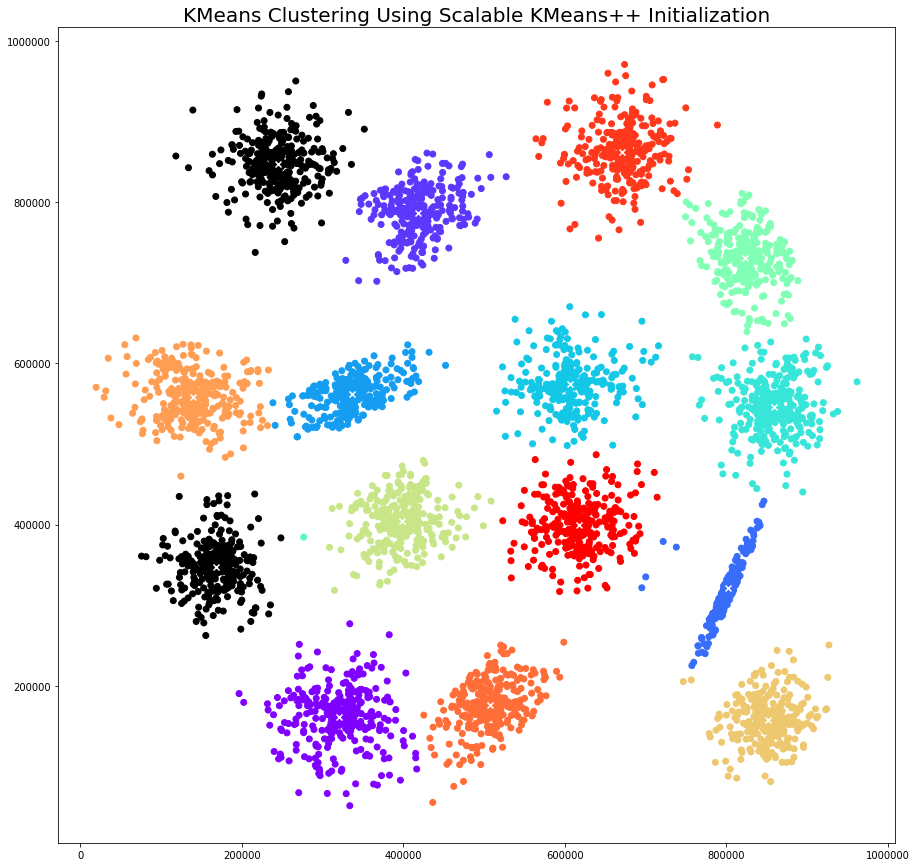

In [224]:
#scalable k means++
palette= plt.cm.rainbow(np.linspace(0,1,k)) 
centroids1 = model.cluster_centers_
plt.figure(figsize=(15,15))
plt.scatter (data[:][:,0],data[:][:,1],color = [palette[int(model.labels_[i])] if (model.labels_[i]+1) != true_label[i] else (0,0,0,1) for i in range (0,data.shape[0])])
for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')
plt.title("KMeans Clustering Using Scalable KMeans++ Initialization", fontdict={'fontsize':20})

Text(0.5, 1.0, 'KMeans Clustering Using KMeans++ Initialization')

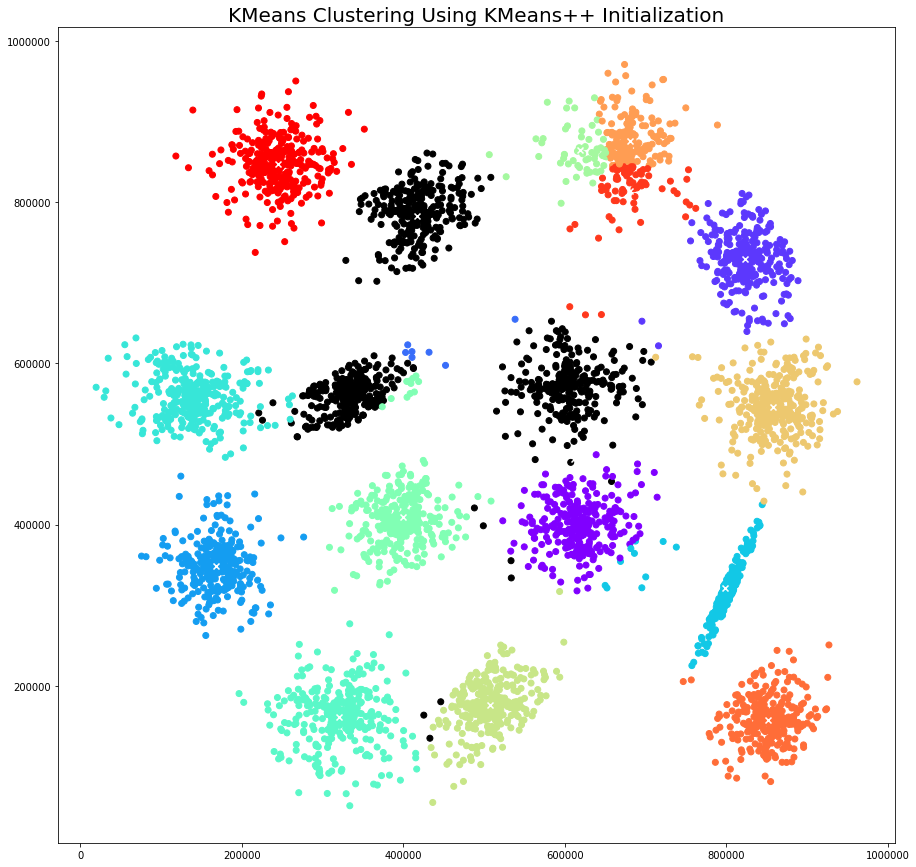

In [226]:
#k means++
palette= plt.cm.rainbow(np.linspace(0,1,k)) 
centroids1 = model2.cluster_centers_
plt.figure(figsize=(15,15))
plt.scatter (data[:][:,0],data[:][:,1],color = [palette[int(model2.labels_[i])] if (model2.labels_[i]+1) != true_label[i] else (0,0,0,1) for i in range (0,data.shape[0])])
for j in range(k):
    plt.scatter(centroids1[j,0],centroids1[j,1],color = 'w',marker='x')
plt.title("KMeans Clustering Using KMeans++ Initialization", fontdict={'fontsize':20})